In [7]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import torch
from custom_transformers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from augmented_generator import *

## Load data

In [8]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


## Test Data Generator (with fraction 60% to visualize results)

Adding new samples

In [9]:
random_pixel_cutout = RandomPixelCutout(max_cutout_size=0.3, color=False)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=4, shuffle=True, augmentor= random_pixel_cutout, augment_fraction=0.6, overwrite=False)

batch_x, batch_y = generator[0]

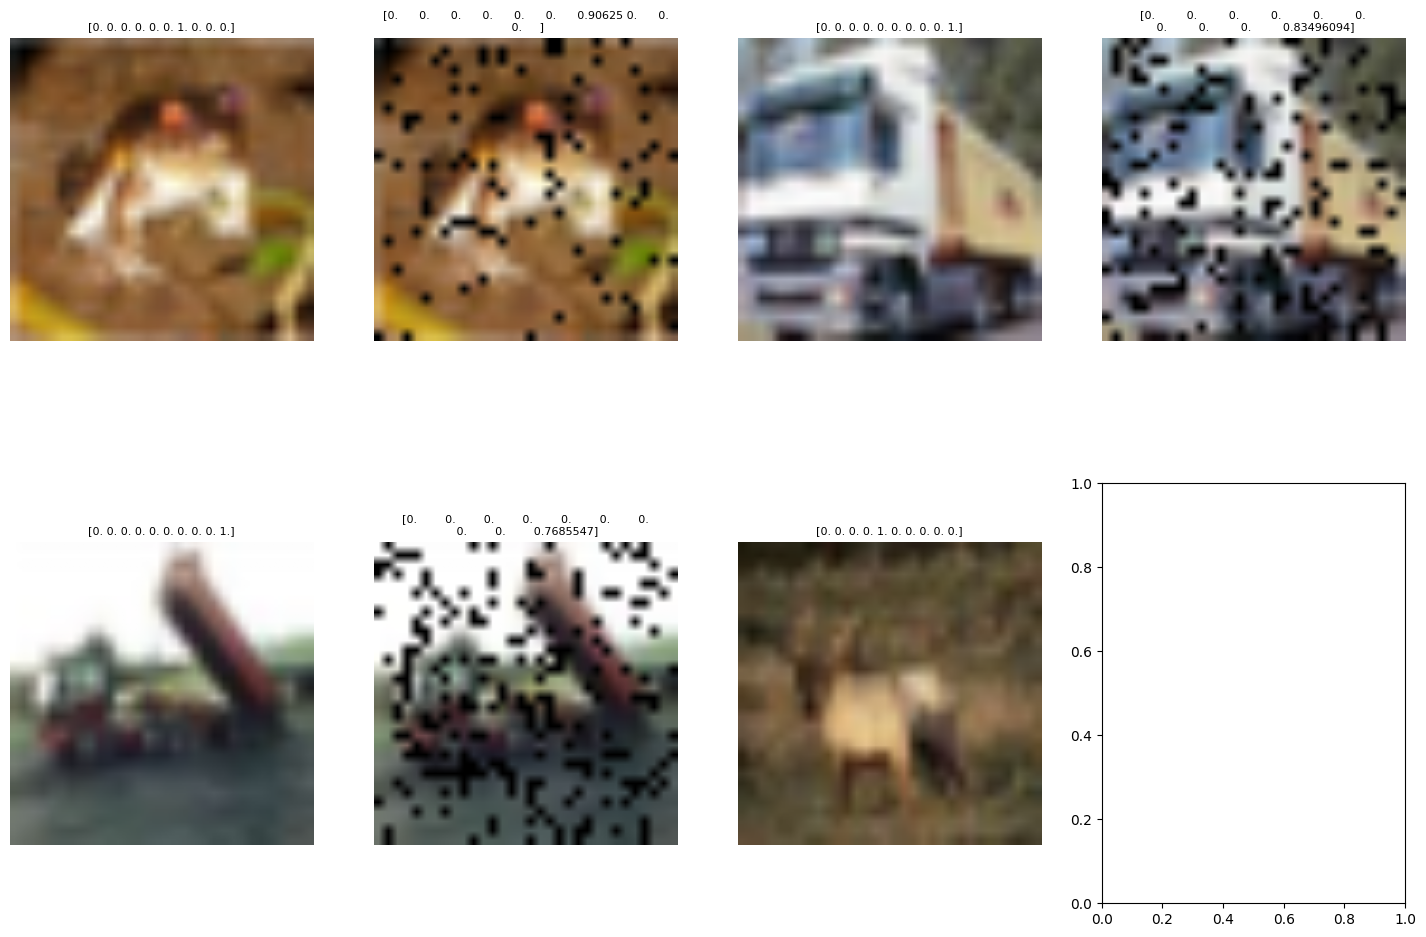

In [10]:
#function to denormalize Restnet preprocessing for visualization purposes
def denormalize_resnet(x):
    x = x.copy()
    x[..., 0] += 103.939  # Blue
    x[..., 1] += 116.779  # Green
    x[..., 2] += 123.68   # Red
    # Zamiana BGR -> RGB
    x = x[..., ::-1]
    x = np.clip(x / 255.0, 0, 1)
    return x

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

As we can see some of the images are augmented with soft labels and added to the data and some have their original labels but with one hot encoding

With overwrite

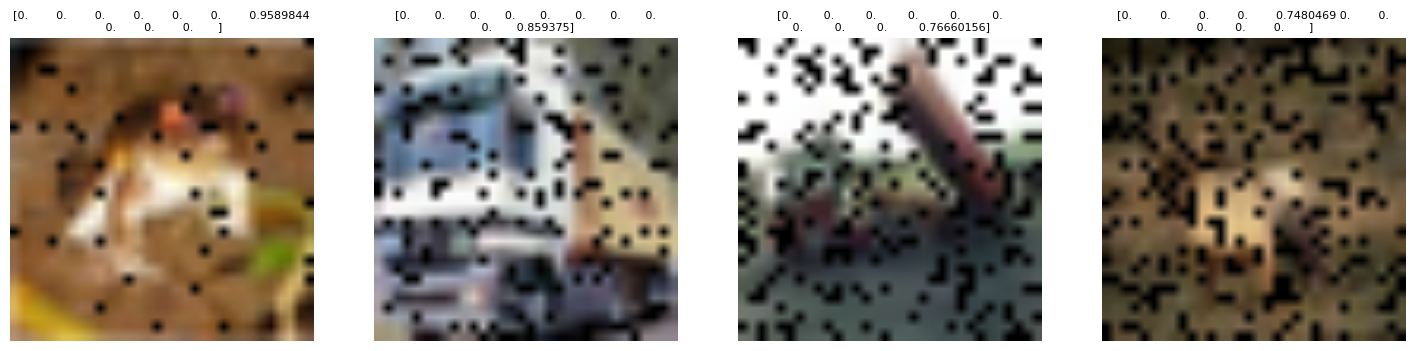

In [11]:
random_pixel_cutout = RandomPixelCutout(max_cutout_size=0.3, color=False)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=4, shuffle=True, augmentor= random_pixel_cutout, augment_fraction=0.6, overwrite=True)

batch_x, batch_y = generator[0]


n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## Restnet Training - Random Pixels

5% of augmented data, max covered area 20%

In [13]:

random_pixel_cutout = RandomPixelCutout(0.2, color=False)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Create generators
train_gen = AugmentedCIFAR10Generator(
    X_train, 
    Y_train,  
    batch_size=64,
    augmentor=random_pixel_cutout, 
    augment_fraction=0.05,
    overwrite=False
)

test_gen = AugmentedCIFAR10Generator(
    X_test, 
    Y_test,
    batch_size=64,
    shuffle=False,  # No augmentation for test set
    augmentor=None
)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Works with both one-hot and soft labels
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=5
)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2308s 3s/step - accuracy: 0.7205 - loss: 0.8415 - val_accuracy: 0.8856 - val_loss: 0.3327
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2199s 3s/step - accuracy: 0.8319 - loss: 0.4986 - val_accuracy: 0.8746 - val_loss: 0.3640
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2195s 3s/step - accuracy: 0.8154 - loss: 0.6305 - val_accuracy: 0.8766 - val_loss: 0.4094
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2209s 3s/step - accuracy: 0.7883 - loss: 1.1852 - val_accuracy: 0.7866 - val_loss: 1.7470
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2258s 3s/step - accuracy: 0.7828 - loss: 1.9946 - val_accuracy: 0.8313 - val_loss: 1.6517


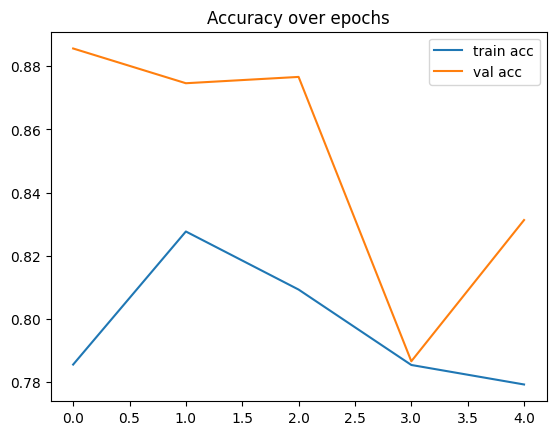

In [14]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

15% augmented data

In [15]:
random_pixel_cutout = RandomPixelCutout(0.1, color=False)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Create generators
train_gen = AugmentedCIFAR10Generator(
    X_train, 
    Y_train,  
    batch_size=32,
    augmentor=random_pixel_cutout, 
    augment_fraction=0.15,
    overwrite=False
)

test_gen = AugmentedCIFAR10Generator(
    X_test, 
    Y_test,
    batch_size=32,
    shuffle=False,  # No augmentation for test set
    augmentor=None
)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Works with both one-hot and soft labels
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=7
)

Epoch 1/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2719s 2s/step - accuracy: 0.7168 - loss: 0.8503 - val_accuracy: 0.8780 - val_loss: 0.3477
Epoch 2/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2464s 2s/step - accuracy: 0.7937 - loss: 0.6608 - val_accuracy: 0.7954 - val_loss: 0.7783
Epoch 3/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3866s 2s/step - accuracy: 0.7543 - loss: 1.6003 - val_accuracy: 0.8303 - val_loss: 1.2489
Epoch 4/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3920s 3s/step - accuracy: 0.7465 - loss: 3.8492 - val_accuracy: 0.8526 - val_loss: 2.1308
Epoch 5/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2404s 2s/step - accuracy: 0.7368 - loss: 7.4658 - val_accuracy: 0.8591 - val_loss: 3.5390
Epoch 6/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2403s 2s/step - accuracy: 0.7338 - loss: 12.4397 - val_accuracy: 0.7747 - val_loss: 9.3265
Epoch 7/7
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2431s 2s/step - accuracy: 0.7344 - loss: 18.5765 - val_accuracy: 0.8602 - val_loss: 7.8951


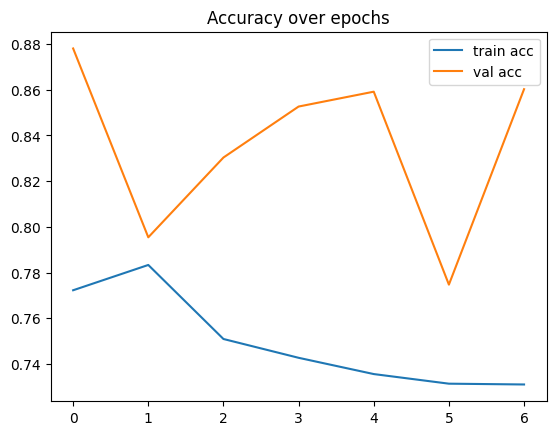

In [16]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()